### Data Preparation

In [ ]:
# Kaggle Install 
#! pip install -Uq kaggle
#! pip install -Uq fastai==2.2.5

In [16]:
# Kaggle Directory 
#! mkdir "C:\Users\jeron\9445 Finals Project Team U and X\.kaggle"
#! copy "C:\Users\jeron\9445 Finals Project Team U and X\.kaggle\kaggle.json"
# chmod 600 C:\Users\jeron\9445 Finals Project Team U and X\.kaggle\kaggle.json --> Download "Git for Windows" and run command through there

        1 file(s) copied.


In [19]:
# Make sure to copy the kaggle.json to Users/""/.kaggle folder; make .kaggle folder if not available
#! kaggle datasets download nikitarom/planets-dataset
# Unzip file manually once downloaded, file will be 1.5 gb so download might take a while

'unzip' is not recognized as an internal or external command,
operable program or batch file.


### Initial Model Scripts

In [2]:
#! pip install fastai
#import fastai
from fastai.vision.all import *
path = Path('C:/Users/jeron/planet/planet')

In [3]:
path.ls()

(#4) [Path('C:/Users/jeron/planet/planet/sample_submission.csv'),Path('C:/Users/jeron/planet/planet/test-jpg'),Path('C:/Users/jeron/planet/planet/train-jpg'),Path('C:/Users/jeron/planet/planet/train_classes.csv')]

In [4]:
train_df = pd.read_csv(path/'train_classes.csv')
train_df

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


In [5]:
def get_data(size=224,bs=64,data_df=train_df):
    dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                       splitter=RandomSplitter(seed=42),
                       get_x=ColReader(0, pref=f'{path}/train-jpg/', suff='.jpg'),
                       get_y=ColReader(1, label_delim=' '),
                       item_tfms = Resize(size),
                       batch_tfms = [*aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.),
                                     Normalize.from_stats(*imagenet_stats)]
                      )
    return dblock.dataloaders(data_df,bs=bs)

In [6]:
dls = get_data(128,256)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


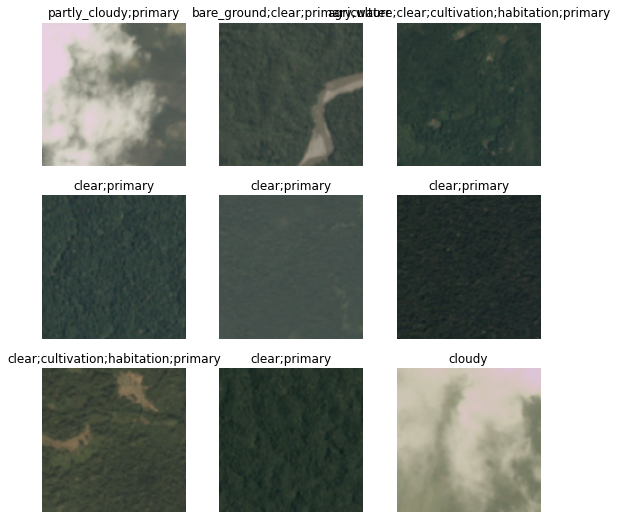

In [7]:
dls.show_batch()

### Training

In [8]:
metrics = [partial(accuracy_multi, thresh=0.2), FBetaMulti(beta = 2, average = 'samples', thresh = 0.2)]
cbs = [MixUp]

In [9]:
#this might crash your computer btw
learn = cnn_learner(dls, resnet50, metrics=metrics, cbs=cbs).to_fp16()
learn.lr_find()

C:\Users\jeron\anaconda3\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\jeron\anaconda3\lib\site-packages\torch\cuda\amp\grad_scaler.py:115: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


In [1]:
learn.fine_tune(6, base_lr=2e-2, freeze_epochs=4)

NameError: name 'learn' is not defined

In [ ]:
learn.save('resnet50-128')

In [ ]:
learn.show_results()

### Predicting 

In [ ]:
learn.export() # if we want .pkl file for proper end to end deployment (file will be saved as export.pkl)

In [ ]:
additional_test_path = Path('test-jpg-additional/test-jpg-additional')
test_path = Path('planet/planet/test-jpg')
submission_df = pd.read_csv(path/'sample_submission.csv')
testing_path = (submission_df['image_name'] + '.jpg').apply(lambda x: test_path/x if x.startswith('test') else additional_test_path/x)

def prediction(filename='submission.csv', tta=False):
    tst_dl = learn.dls.test_dl(testing_path)
    if tta:
        predictions = learn.tta(dl = tst_dl)
    else:
        predictions = learn.get_preds(dl = tst_dl)
    predlist = [' '.join(learn.dls.vocab[i]) for i in (predictions[0] > 0.2)]

    df = submission_df
    df['tags'] = predlist

    df.to_csv(filename, index=False)
    return df

In [ ]:
prediction('submission_tta.csv', tta=True)